In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db = mysql.connector.connect(host = "localhost",
                             username = "root",
                             password = "7310",
                             database = "ecommerce")

cur = db.cursor()

# List all unique cities where customers are located

In [62]:
query = """select distinct customer_city from customers"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df.head()
df

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


# Count the number of orders placed in 2017.

In [63]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """
cur.execute(query)
data = cur.fetchall()
data[0][0]

90202

# Find the total sales per category

In [64]:
query = """ select UPPER(products.product_category) category, round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id = order_items.product_id 
join payments 
on payments.order_id = order_items.order_id
group by category"""

cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data, columns = ["category","sales"])
df                  

,category,sales
0,PERFUMERY,4053909.28
1,FURNITURE DECORATION,11441411.13
2,TELEPHONY,3895056.41
3,BED TABLE BATH,13700429.37
4,AUTOMOTIVE,6818354.65
...,...,...
69,CDS MUSIC DVDS,9595.44
70,LA CUISINE,23308.24
71,FASHION CHILDREN'S CLOTHING,6285.36
72,PC GAMER,17395.44


# Calculate the percentage of orders that were paid in installment

In [65]:
query = """ select sum(case when payment_installments >= 1 then 1 else 0 end)/count(*)*100 from payments """
cur.execute(query)
data = cur.fetchall()
data[0][0]

Decimal('99.9981')

# Count the number of customers from each state

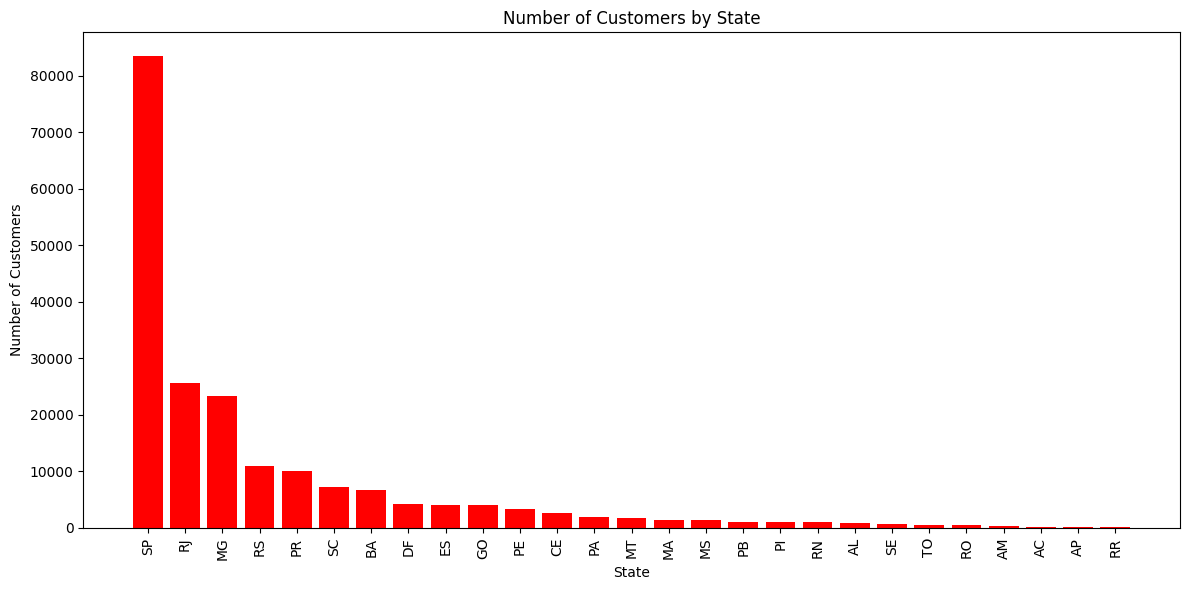

In [66]:



query = """ SELECT customer_state, COUNT(customer_id)
FROM customers 
GROUP BY customer_state
"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=["State", "Customers"])
df = df.sort_values(by="Customers", ascending = False)

plt.figure(figsize=(12, 6)) 
plt.bar(df["State"], df["Customers"], color='red')
plt.xticks(rotation=90)
plt.xlabel("State")
plt.ylabel("Number of Customers")
plt.title("Number of Customers by State")
plt.tight_layout() 
plt.show()


# Calculate the number of orders per month in 2018

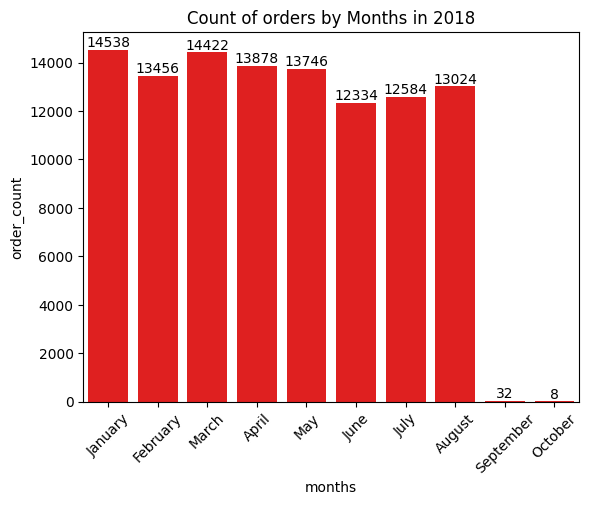

In [67]:
query = """SELECT MONTHNAME(order_purchase_timestamp) AS months, 
       COUNT(order_id) AS order_count
FROM orders 
WHERE YEAR(order_purchase_timestamp) = 2018
GROUP BY months
"""

cur.execute(query)
data = cur.fetchall()


df = pd.DataFrame(data, columns=["months", "order_count"])
O = ["January", "February", "March", "April", "May", "June","July", "August", "September", "October"]

ax = sns.barplot(x=df["months"], y=df["order_count"], data=df, order=O, color = "red")

plt.xticks(rotation=45)
plt.title("Count of orders by Months in 2018")
ax.bar_label(ax.containers[0])
plt.show()



# Find the average number of products per order, grouped by customer city

In [68]:
query = """WITH count_per_order AS (
    SELECT orders.order_id, orders.customer_id, COUNT(order_items.order_id) AS oc
    FROM orders 
    JOIN order_items 
    ON orders.order_id = order_items.order_id
    GROUP BY orders.order_id, orders.customer_id)

SELECT customers.customer_city, 
       ROUND(AVG(count_per_order.oc), 2) AS average_order
FROM customers 
JOIN count_per_order 
ON customers.customer_id = count_per_order.customer_id
GROUP BY customers.customer_city order by average_order desc
"""
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data , columns = ["customer city","Average order"])
df.head(20)


,customer city,Average order
0,padre carvalho,28.00
1,celso ramos,26.00
2,datas,24.00
3,candido godoi,24.00
4,matias olimpio,20.00
5,cidelandia,16.00
6,picarra,16.00
7,morro de sao paulo,16.00
8,teixeira soares,16.00
9,curralinho,16.00


# Calculate the percentage of total revenue contributed by each product category

In [69]:
query = """ select UPPER(products.product_category) category, round((sum(payments.payment_value)/(select sum(payment_value) from payments)*100),2)sales
from products join order_items
on products.product_id = order_items.product_id 
join payments 
on payments.order_id = order_items.order_id
group by category
order by sales desc """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data , columns = ["category","percentage distribution"])
df.head(20)

,category,percentage distribution
0,BED TABLE BATH,42.79
1,HEALTH BEAUTY,41.41
2,COMPUTER ACCESSORIES,39.61
3,FURNITURE DECORATION,35.73
4,WATCHES PRESENT,35.71
5,SPORT LEISURE,34.78
6,HOUSEWARES,27.35
7,AUTOMOTIVE,21.30
8,GARDEN TOOLS,20.95
9,COOL STUFF,19.48


# Identify the correlation between product price and the number of times a product has been purchased

In [70]:
query = """select products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data , columns = ["category","order_count","price"])
import numpy as np

arr1=df["order_count"]
arr2=df["price"]

a = np.corrcoef([arr1,arr2])
print("the correlation between product price and the number of times a product is : ", a[0][-1])

the correlation between product price and the number of times a product is :  -0.10631514167157562


# Calculate the total revenue generated by each seller, and rank them by revenue

In [80]:
query =""" select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data , columns = ["seller_id","revenue","rank"],)
df.head(20)


,seller_id,revenue,rank
0,7c67e1448b00f6e969d365cea6b010ab,2.028668e+06,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,1.232888e+06,2
2,4a3ca9315b744ce9f8e9374361493884,1.204981e+06,3
3,1f50f920176fa81dab994f9023523100,1.161014e+06,4
4,53243585a1d6dc2643021fd1853d8905,1.139612e+06,5
5,da8622b14eb17ae2831f4ac5b9dab84a,1.088877e+06,6
6,4869f7a5dfa277a7dca6462dcf3b52b2,1.056664e+06,7
7,955fee9216a65b617aa5c0531780ce60,9.452892e+05,8
8,fa1c13f2614d7b5c4749cbc52fecda94,8.260529e+05,9
9,7e93a43ef30c4f03f38b393420bc753a,7.405368e+05,10


# Calculate the moving average of order values for each customer over their order history

In [81]:
query = """select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data , columns = ["seller_id","time_stamp", "price", "moving_averages"])
df

,seller_id,time_stamp,price,moving_averages
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
...,...,...,...,...
415539,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000
415540,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
415541,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
415542,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


# Calculate the cumulative sales per month for each year

In [84]:
query = """select years, months, payment, sum(payment)
over(order by years, months) cumulative_sales from
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["year","month","payment","cumulative sales"])
df


,year,month,payment,cumulative sales
0,2016,9,1008.96,1008.96
1,2016,10,236361.92,237370.88
2,2016,12,78.48,237449.36
3,2017,1,553952.16,791401.52
4,2017,2,1167632.04,1959033.56
5,2017,3,1799454.40,3758487.96
6,2017,4,1671152.12,5429640.08
7,2017,5,2371675.28,7801315.36
8,2017,6,2045105.52,9846420.88
9,2017,7,2369531.68,12215952.56


# Calculate the year-over-year growth rate of total sales

In [88]:
query = """with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)
 
select years, ((payment-lag(payment,1) over(order by years))/lag(payment,1) over(order by years)) * 100 from a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "yoy % growth"])
df


,years,yoy % growth
0,2016,NaN
1,2017,12112.703757
2,2018,20.000924


# Identify the top 3 customers who spent the most money in each year

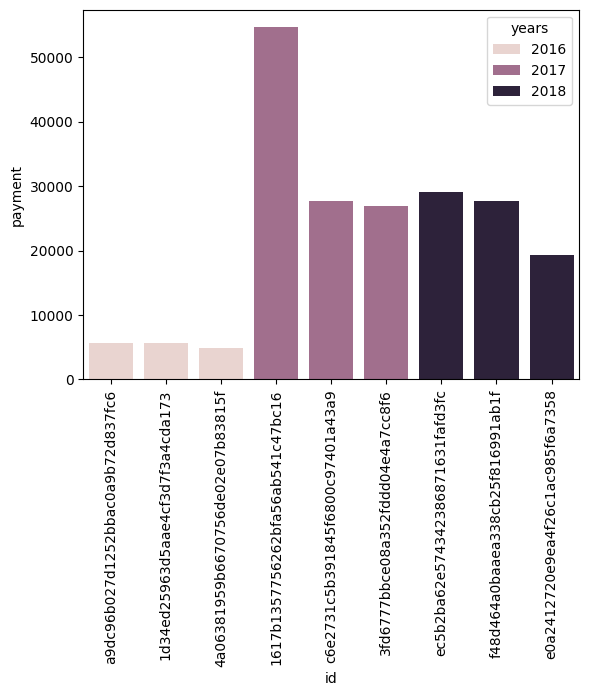

In [89]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "id", "payment", "rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()